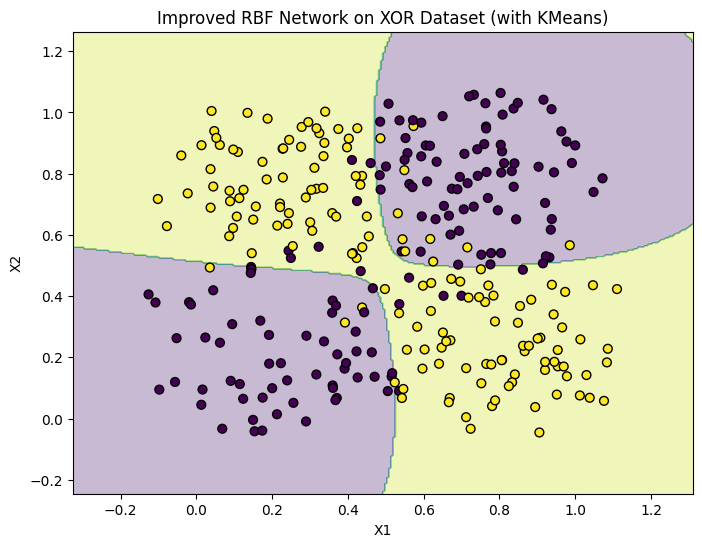

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge

# XOR dataset generator
def generate_noisy_xor(n_samples=300, noise=0.08):
    X = np.random.rand(n_samples, 2)
    y = np.array([0 if (x[0] < 0.5 and x[1] < 0.5) or (x[0] >= 0.5 and x[1] >= 0.5) else 1
                  for x in X])
    X += noise * np.random.randn(n_samples, 2)
    return X, y

X_toy, y_toy = generate_noisy_xor()

# RBF Network
class RBFNetwork:
    def __init__(self, num_centers, sigma=None):
        self.num_centers = num_centers
        self.sigma = sigma
        self.centers = None
        self.weights = None

    def _rbf(self, x, c):
        return np.exp(-np.linalg.norm(x - c) ** 2 / (2 * self.sigma ** 2))

    def _design_matrix(self, X):
        G = np.zeros((X.shape[0], self.num_centers))
        for i, x in enumerate(X):
            for j, c in enumerate(self.centers):
                G[i, j] = self._rbf(x, c)
        return G

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.num_centers, random_state=42).fit(X)
        self.centers = kmeans.cluster_centers_

        if self.sigma is None:
            dists = [np.linalg.norm(c1 - c2)
                     for i, c1 in enumerate(self.centers)
                     for j, c2 in enumerate(self.centers) if i < j]
            self.sigma = np.mean(dists)

        G = self._design_matrix(X)
        self.weights = Ridge(alpha=1e-3).fit(G, y)

    def predict(self, X):
        G = self._design_matrix(X)
        y_pred = self.weights.predict(G)
        return (y_pred >= 0.5).astype(int)  # threshold for classification

# Train RBF network
num_centers = 20  # Try with more centers
rbf_net = RBFNetwork(num_centers)
rbf_net.fit(X_toy, y_toy)

# Visualize decision boundary
x_min, x_max = X_toy[:, 0].min() - 0.2, X_toy[:, 0].max() + 0.2
y_min, y_max = X_toy[:, 1].min() - 0.2, X_toy[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = rbf_net.predict(grid_points).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3,)
plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy, s=40, edgecolors='k')
plt.title("Improved RBF Network on XOR Dataset (with KMeans)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()
